# Time-Series Forecasting: Predicting Stock Prices Using LSTMs

We are going to build a multi-layer LSTM recurrent neural network to predict the last value of a sequence of values i.e. the TESLA stock price in this example.

In [2]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

### Data
Thanks to Yahoo finance we can get the data for free. Use the following link to get the stock price history of TESLA: https://finance.yahoo.com/quote/TSLA/history?period1=1436486400&period2=1594339200&interval=1d&filter=history&frequency=1d

In [3]:
df=pd.read_csv("TSLA.csv")
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


In [4]:
training_set = df.iloc[:800, 1:2].values
test_set = df.iloc[800:, 1:2].values

It’s a good idea to normalize the data before model fitting. This will boost the performance. Let’s build the input features with time lag of 1 day (lag 1):

In [5]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)

### Modeling
We have now reshaped the data into the following format (#values, #time-steps, #one dimensional output).
Now, it’s time to build the model. We will build the LSTM with 50 neurons and 4 hidden layers. Finally, we will assign 1 neuron in the output layer for predicting the normalized stock price. We will use the MSE loss function and the Adam stochastic gradient descent optimizer.

In [6]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
24/24 [==============================] - 9s 75ms/step - loss: 0.1359
Epoch 2/100
24/24 [==============================] - 2s 72ms/step - loss: 0.0220
Epoch 3/100
24/24 [==============================] - 2s 72ms/step - loss: 0.0117
Epoch 4/100
24/24 [==============================] - 2s 72ms/step - loss: 0.0126
Epoch 5/100
24/24 [==============================] - 2s 71ms/step - loss: 0.0124
Epoch 6/100
24/24 [==============================] - 2s 71ms/step - loss: 0.0120
Epoch 7/100
24/24 [==============================] - 2s 71ms/step - loss: 0.0141
Epoch 8/100
24/24 [==============================] - 2s 73ms/step - loss: 0.0141
Epoch 9/100
24/24 [==============================] - 2s 73ms/step - loss: 0.0105
Epoch 10/100
24/24 [==============================] - 2s 72ms/step - loss: 0.0095
Epoch 11/100
24/24 [==============================] - 2s 73ms/step - loss: 0.0097
Epoch 12/100
24/24 [==============================] - 2s 71ms/step - loss: 0.0100
Epoch 13/100
24/24 [=====

### Prepare the test data (reshape them):

In [7]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(459, 60, 1)


### Make Predictions using the test set

In [8]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

### Let’s visualize the results

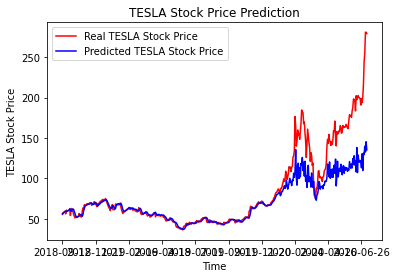

In [11]:
# Visualising the results
plt.plot(df.loc[800:, 'Date'],dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[800:, 'Date'],predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()